# The Mouse Cortical Model + Advanced Features

The goal of this chapter is an introduction of how to build, optimize, and simulate a more realistic brain model using some of the more advanced features of the BMTK. Will we use a reduced version of the Mouse Visual Cortical models, the full version can be found [here](https://portal.brain-map.org/explore/models/mv1-all-layers).


In [43]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import h5py
import glob

from bmtk.analyzer.spike_trains import plot_rates_boxplot, plot_rates, plot_raster
from bmtk.utils import sonata
from bmtk.utils.reports import SpikeTrains


pd.set_option('display.max_rows', None)

## [6A. Building the Model](6A.%20Building%20the%20L4%20Network.ipynb)

We have already built a reduced model of the Mouse Primary Visual Cortex with only Layer 4 cells which has been saved in the **network/** directory. The rules used to build the network are not necessary for the rest of the chapter, and can be time consuming to rebuild from scratch. But should one be interested in how the network was built more details be found [here](6A.%20Building%20the%20L4%20Network.ipynb).

The core of the network is internal "L4" (Layer 4) cells saved in the l4_nodes.h5 and l4_node_types.csv files. To get a sense of the make-up of the network let's use ```bmtk.utils.sonata``` functionality to load the nodes into a Panda's dataframe:

In [5]:
net = sonata.File(
    data_files='network/l4_nodes.h5',
    data_type_files='network/l4_node_types.csv'
)
l4_nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
l4_nodes_df['node_count'] = 1
l4_nodes_df[['layer', 'ei', 'model_name',  'dynamics_params', 'model_template', 'model_type', 'node_count']].groupby(['layer', 'ei', 'model_name', 'model_template', 'model_type', 'dynamics_params']).agg('count')

node_count
layer ei model_name       model_template        model_type   dynamics_params                               
VisL4 e  Rorb_314642645   nest:glif_lif_asc_psc point_neuron 314642645_glif_lif_asc_config.json         594
         Scnn1a_517982558 nest:glif_lif_asc_psc point_neuron 517982558_glif_lif_asc_config.json         686
         other_483018019  nest:glif_lif_asc_psc point_neuron 483018019_glif_lif_asc_config.json         732
      i  Htr3a_474626527  nest:glif_lif_asc_psc point_neuron 474626527_glif_lif_asc_config.json          61
         Pvalb_478958894  nest:glif_lif_asc_psc point_neuron 478958894_glif_lif_asc_config.json         223
         Sst_501282204    nest:glif_lif_asc_psc point_neuron 501282204_glif_lif_asc_config.json         119

Let us also look at the overall makeup of the recurrent (L4 --> L4) connections

In [6]:
l4_edges_df = pd.read_csv('network/l4_l4_edge_types.csv', sep=' ').sort_values(['dynamics_params', 'target_query'])
with h5py.File('network/l4_l4_edges.h5', 'r') as h5:
    edge_ids, edge_counts = np.unique(h5['/edges/l4_to_l4/edge_type_id'][()], return_counts=True)
    edge_counts_df = pd.DataFrame({'edge_type_id': edge_ids, 'counts': edge_counts})
    l4_edges_df = l4_edges_df.merge(edge_counts_df, how='left', on='edge_type_id')

l4_edges_df.set_index(['edge_type_id', 'target_query', 'source_query', 'dynamics_params'])

,,,,delay,weight_function,syn_weight,model_template,weight_sigma,counts
edge_type_id,target_query,source_query,dynamics_params,,,,,,
107,cell_line=='e4Rorb',cell_line=='e4Rorb',e2e.json,1.3,DirectionRule_EE,5.154132,static_synapse,30.0,26641
113,cell_line=='e4Rorb',cell_line=='e4Scnn1a',e2e.json,1.3,DirectionRule_EE,5.154132,static_synapse,30.0,29888
125,cell_line=='e4Rorb',cell_line=='e4other',e2e.json,1.3,DirectionRule_EE,5.154132,static_synapse,30.0,32289
108,cell_line=='e4Scnn1a',cell_line=='e4Rorb',e2e.json,1.3,DirectionRule_EE,13.687266,static_synapse,30.0,29926
114,cell_line=='e4Scnn1a',cell_line=='e4Scnn1a',e2e.json,1.3,DirectionRule_EE,13.687266,static_synapse,30.0,33425
126,cell_line=='e4Scnn1a',cell_line=='e4other',e2e.json,1.3,DirectionRule_EE,13.687266,static_synapse,30.0,36140
110,cell_line=='e4other',cell_line=='e4Rorb',e2e.json,1.3,DirectionRule_EE,5.443508,static_synapse,30.0,31895
116,cell_line=='e4other',cell_line=='e4Scnn1a',e2e.json,1.3,DirectionRule_EE,5.443508,static_synapse,30.0,36262
128,cell_line=='e4other',cell_line=='e4other',e2e.json,1.3,DirectionRule_EE,5.443508,static_synapse,30.0,38955


## [6B. Generating Synaptic Inputs](6B.%20Creating%20Synaptic%20Inputs.ipynb)

Next step is generating spike-train inputs for the "lgn" and "bkg" feed-forward synaptic inputs. Generating realistic inputs for the full "lgn" model using ```FilterNet``` can be time consuming, so we already pre-generated them in the **inputs/** directory. Any file of the format _spikes.\*.h5_ will contain SONATA spike-trains we can us when running the mouse cortical model:


In [7]:
print('Valid SONATA inputs:')
for spikes_file in glob.glob('inputs/spikes*.h5'):
    print('->', spikes_file)

Valid SONATA inputs:
-> inputs/spikes.gratings.0deg_2Hz.h5
-> inputs/spikes.gratings.45deg_2Hz.h5
-> inputs/spikes.gratings.90deg_2Hz.h5
-> inputs/spikes.gratings.90deg_4Hz.h5
-> inputs/spikes.gratings.dg_90deg_4Hz.h5


However should you want to generate differet set of input spikes, or regenerate the existing ones (required if the lgn coordinates have been changes since spiking is dependent on the location inside of receptive field) please see the notebook [here](6B.%20Creating%20Synaptic%20Inputs.ipynb).

## 6C. Running the Model


#### LGN Feedforward connections only

First we'll start by testing and optimizing the network with LGN feedforward connections only, that is without the recurrent connections. If our network is not working as expected with only feedforward inputs, then it won't work when recurrent connections are added. The main focus will be on the synaptic weights or *syn_weight* parameter such that different cell-type models are spiking with an appropiate base-line firing-rate.

To run the simulation with only feedforward synaptic connections all we need to do is adjust the "network" section of the configuration so that "l4->l4" and "bkg->l4" connections are excluded.

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l4_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l4_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/lgn_nodes.h5",
        "node_types_file": "$NETWORK_DIR/lgn_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/lgn_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/lgn_l4_edge_types.csv"
      }
    ]
  }

```

In [10]:
from bmtk.simulator import pointnet


configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-06-02 10:53:01,061 [INFO] Created log file
2022-06-02 10:53:01,108 [INFO] Batch processing nodes for l4/0.
2022-06-02 10:53:01,229 [INFO] Batch processing nodes for lgn/0.
2022-06-02 10:53:01,259 [INFO] Setting up output directory
2022-06-02 10:53:01,261 [INFO] Building cells.
2022-06-02 10:53:01,371 [INFO] Building recurrent connections
2022-06-02 10:53:01,372 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-02 10:53:17,666 [INFO] Network created.
2022-06-02 10:53:17,724 [INFO] Starting Simulation
2022-06-02 10:53:25,563 [INFO] Simulation finished, finalizing results.
2022-06-02 10:53:26,301 [INFO] Done.


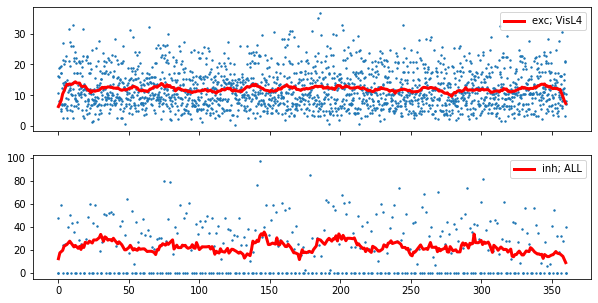

In [11]:
def plot_tunning_angle_fr(spikes_path, fr_window=(500.0, 3000.0), convolv_window=10):
    dur_secs = (fr_window[1] - fr_window[0]) / 1000.0

    net = sonata.File(
        data_files='network/l4_nodes.h5',
        data_type_files='network/l4_node_types.csv'
    )
    nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
    nodes_df = nodes_df[['node_id', 'node_type_id', 'model_name', 'tuning_angle', 'model_type', 'layer', 'ei']]

    spikes = SpikeTrains.load('output/spikes.h5')
    spikes_df = spikes.to_dataframe(population='l4')

    fr_df = spikes_df['node_ids'].value_counts().rename_axis('node_id').to_frame('spike_counts').reset_index()
    fr_df['firing_rates'] = fr_df['spike_counts'].values / dur_secs
    fr_df['node_id'] = fr_df['node_id'].astype(np.uint64)
    fr_df = fr_df.merge(nodes_df, how='right', on='node_id')
    fr_df['spike_counts'] = fr_df['spike_counts'].fillna(0.0)
    fr_df['firing_rates'] = fr_df['firing_rates'].fillna(0.0)
    fr_df['tuning_rounded'] = 0.0

    def create_subplot(ax, grp_df, label):
        ax.scatter(grp_df['tuning_angle'], grp_df['firing_rates'], s=2)
        
        # print(grp_df.index.values)
        fr_avgs = pd.DataFrame({
            'tuning_rounded': np.floor(grp_df['tuning_angle']),
            'firing_rates': grp_df['firing_rates']
        }).groupby('tuning_rounded').agg(np.mean)
        
        if convolv_window and len(fr_avgs['firing_rates']) > convolv_window:
            filter = np.array([1.0] * int(convolv_window)) / float(convolv_window)
            fr_avgs['firing_rates'] = np.convolve(fr_avgs['firing_rates'].values, filter, mode='same')

        ax.plot(fr_avgs['firing_rates'], c='r', linewidth=3, label=label)
        ax.legend(fontsize=10, loc='upper right')

    # plot excitatory cells by layer
    nrows = 2
    fig, axes = plt.subplots(nrows, 1, figsize=(10, 5))
    for r, layer in enumerate(['VisL4']):
        exc_df = fr_df[(fr_df['ei'] == 'e') & (fr_df['layer'] == layer)]
        create_subplot(axes[r], exc_df, 'exc; {}'.format(layer))

    # plot inhibitory cells
    inh_df = fr_df[fr_df['ei'] == 'i']
    create_subplot(axes[r+1], inh_df, 'inh; ALL')

    for r in range(nrows):
        if r != (nrows - 1):
            axes[r].set_xticklabels([])

    plt.show()


plot_tunning_angle_fr('output/spikes.h5')

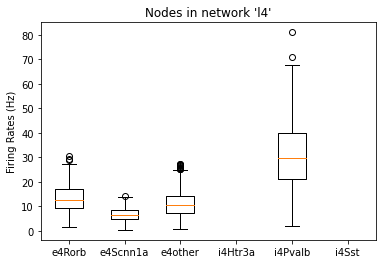

In [12]:
from bmtk.analyzer.spike_trains import plot_rates_boxplot, plot_rates

_ = plot_rates_boxplot(config_file='config.simulation_pointnet.json', group_by='cell_line')

Based on these initial results, it looks like we will want to increase the firing rates for most of the populations, the best way of doing that is to increase the synaptic strengths of LGN --> L4 connections.

This can be done by rebuilding the network, but for larger models this can be time consuming, plus we will probably need to adjust weights multiple times. Instead the BMTK has a way of adjusting the synaptic weights dynamically during simulation-time. In the SONATA edges file for LGN --> L4 connections we include an optional column called **weight_function**:



In [7]:
edge_types_df = pd.read_csv('network/lgn_l4_edge_types.csv', sep=' ')
edge_types_df.style.applymap(lambda *_: 'background-color: yellow', subset=pd.IndexSlice[:, 'weight_function'])

,edge_type_id,target_query,source_query,dynamics_params,model_template,syn_weight,delay,weight_function
0,100,model_name=='Sst_501282204',*,i2e.json,static_synapse,0.000000,1.700000,set_syn_weight
1,101,model_name=='Rorb_314642645',*,e2e.json,static_synapse,0.518667,1.700000,set_syn_weight
2,102,model_name=='Scnn1a_517982558',*,e2e.json,static_synapse,0.517374,1.700000,set_syn_weight
3,103,model_name=='Htr3a_474626527',*,i2e.json,static_synapse,0.000000,1.700000,set_syn_weight
4,104,model_name=='other_483018019',*,e2e.json,static_synapse,0.515249,1.700000,set_syn_weight
5,105,model_name=='Pvalb_478958894',*,i2e.json,static_synapse,1.791676,1.700000,set_syn_weight


*set_syn_weight* is a built-in function that is used by bmtk to calculate synaptic weights for pairs of source/target cells. *set_syn_weight* is a function that takes in a table of edge and cell properties and returns a list of updated synaptic-weight, by default simply by returning the **syn_weigth** times the number of actualy synapses (which defaults to 1 if not explicity stated).

```python
def default_weight_fnc(edge_props, source_nodes, target_nodes):
    return edge_props['syn_weight']*edge_props.nsyns
```

However with bmtk we can override this behavior

In [13]:
from bmtk.simulator import pointnet
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight


@synaptic_weight
def set_syn_weight(edge_props, source_nodes, target_nodes):
    trg_types = target_nodes['cell_line'].values
    syn_weights = edge_props['syn_weight'].values
    nsyns = edge_props.nsyns
    assert(len(trg_types) == len(syn_weights) == len(nsyns))
    
    update_fnc = np.vectorize(lambda i: 2 if i != 'i4Pvalb' else 1)
    update_factor = update_fnc(trg_types)
    updated_syn_weights = update_factor*syn_weights*nsyns
    return updated_syn_weights


configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-06-02 10:53:58,761 [INFO] Created log file
2022-06-02 10:53:58,828 [INFO] Batch processing nodes for l4/0.
2022-06-02 10:53:58,946 [INFO] Batch processing nodes for lgn/0.
2022-06-02 10:53:59,020 [INFO] Setting up output directory
2022-06-02 10:53:59,021 [INFO] Building cells.
2022-06-02 10:53:59,113 [INFO] Building recurrent connections
2022-06-02 10:53:59,114 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-02 10:54:15,309 [INFO] Network created.
2022-06-02 10:54:15,346 [INFO] Starting Simulation
2022-06-02 10:54:22,712 [INFO] Simulation finished, finalizing results.
2022-06-02 10:54:23,360 [INFO] Done.


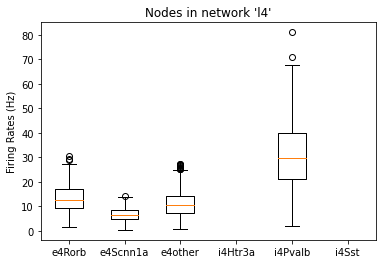

In [14]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

We can use the **weight_function** functionality to help find optimal parameters with a grid-search or gradient-descent. In the following we try to find more appropiate values using a grid-search on the **syn_weight** parameter. We will run the simulation four times in a row, each time increasing/decreasing the **syn_weight** by some factor depending on the edge's target cell_line. Each iteration we'll record the updated **syn_weight** and the cell-line's mean firing-rate so we can plot the results at the end. 


Once we have a better idea of different feed-forward **syn_weight** values are best for different cell-models it will be trivial to update the *lgn_l4_edge_types.csv* **syn_weight** values.


In [22]:
import pandas as pd

from bmtk.analyzer.spike_trains import spike_statistics
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight
from bmtk.simulator import pointnet

grid_search = {
    'e4Rorb': [0.5, 1.0, 1.5, 2.0],
    'e4Scnn1a': [1.0, 1.25, 1.75, 2.0],
    'e4other': [0.5, 1.0, 1.5, 2.0],
    'i4Htr3a': [1.0, 2.0, 2.5, 3.0],
    'i4Pvalb': [0.1, 0.3, 0.6, 0.9],
    'i4Sst': [1.0, 2.0, 2.5, 3.0]
}

# Keeps track of current iteration, plus each iterations weights and firing-rates for graphing later
current_itr = 0
weights_table = {cell_line: [] for cell_line in grid_search.keys()}
fr_table = {cell_line: [] for cell_line in grid_search.keys()}


@synaptic_weight
def set_syn_weight(edge_props, source_nodes, target_nodes):
    target_type = target_nodes['cell_line'].unique()[0]
    old_syn_weight = edge_props['syn_weight'].unique()[0]
    new_syn_weight = old_syn_weight*grid_search[target_type][current_itr]
    
    # Save the updated weights at each iteration
    weights_table[target_type].append(new_syn_weight)
    
    # return new weights
    return new_syn_weight*edge_props.nsyns
    

for i in range(4):
    current_itr = i
    
    print('>> Running iteration {}'.format(i+1))
    configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
    configure.build_env()

    graph = pointnet.PointNetwork.from_config(configure)
    sim = pointnet.PointSimulator.from_config(configure, graph)
    sim.run()

    spike_stats_df = spike_statistics('output/spikes.h5', simulation=sim, group_by='cell_line', populations='l4')
    for cell_line, fr in spike_stats_df['firing_rate']['mean'].items():
        fr_table[cell_line].append(fr)
    


>> Running iteration 0
2022-06-02 11:24:20,274 [INFO] Created log file
2022-06-02 11:24:20,305 [INFO] Batch processing nodes for l4/0.
2022-06-02 11:24:20,383 [INFO] Batch processing nodes for lgn/0.
2022-06-02 11:24:20,472 [INFO] Setting up output directory
2022-06-02 11:24:20,473 [INFO] Building cells.
2022-06-02 11:24:20,583 [INFO] Building recurrent connections
2022-06-02 11:24:20,585 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-02 11:24:32,733 [INFO] Network created.
2022-06-02 11:24:32,765 [INFO] Starting Simulation
2022-06-02 11:24:38,269 [INFO] Simulation finished, finalizing results.
2022-06-02 11:24:38,336 [INFO] Done.
>> Running iteration 1
2022-06-02 11:24:38,770 [INFO] Created log file
2022-06-02 11:24:38,802 [INFO] Batch processing nodes for l4/0.
2022-06-02 11:24:38,885 [INFO] Batch processing nodes for lgn/0.
2022-06-02 11:24:38,978 [INFO] Setting up output directory
2022-06-02 11:24:38,979 [INFO] Building cells.
2022-06-02 11:24:39,085 [INFO] Building 

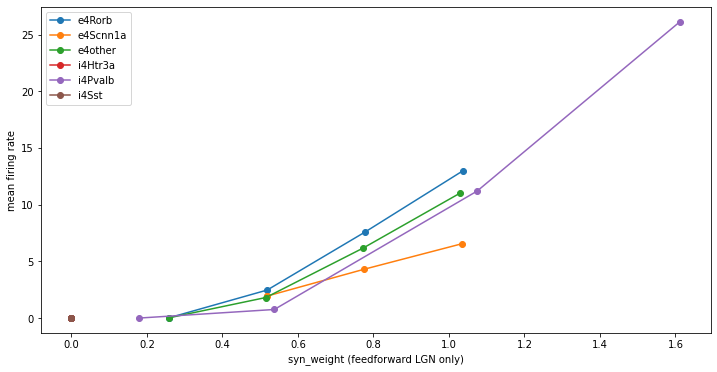

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for cell_line, weights in weights_table.items():
    firing_rates = fr_table[cell_line]
    ax.plot(weights, firing_rates, '-o', label=cell_line)

ax.set_xlabel('syn_weight (feedforward LGN only)')
ax.set_ylabel('mean firing rate')
ax.legend()    
plt.show()

#### Full model

We are now ready to run the simulation with the l4-->l4 current connections added back. These also use the **weight_function**, but instead of overriding the existing *set_syn_weight* it uses custom functions built-in to the network and will be different if connection types are excitatory-to-excitatory or if one of the source/target cell is inhibitory.

In [33]:
edge_types_df = pd.read_csv('network/l4_l4_edge_types.csv', sep=' ')
edge_types_df.iloc[5:10].style.applymap(lambda *_: 'background-color: yellow', subset=pd.IndexSlice[:, 'weight_function'])

,edge_type_id,target_query,source_query,dynamics_params,delay,weight_function,syn_weight,model_template,weight_sigma
5,105,cell_line=='i4Pvalb',cell_line=='i4Sst',i2i.json,1.500000,DirectionRule_others,-1.120146,static_synapse,50.000000
6,106,cell_line=='i4Sst',cell_line=='e4Rorb',e2i.json,1.500000,DirectionRule_others,3.388120,static_synapse,90.000000
7,107,cell_line=='e4Rorb',cell_line=='e4Rorb',e2e.json,1.300000,DirectionRule_EE,5.154132,static_synapse,30.000000
8,108,cell_line=='e4Scnn1a',cell_line=='e4Rorb',e2e.json,1.300000,DirectionRule_EE,13.687266,static_synapse,30.000000
9,109,cell_line=='i4Htr3a',cell_line=='e4Rorb',e2i.json,1.500000,DirectionRule_others,1.027934,static_synapse,90.000000


In [40]:
import math
import numpy as np

from bmtk.simulator import pointnet
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight


@synaptic_weight
def DirectionRule_others(edge_props, source_nodes, target_nodes):
    src_tuning = source_nodes['tuning_angle'].values
    tar_tuning = target_nodes['tuning_angle'].values
    sigma = edge_props['weight_sigma'].values
    nsyn = edge_props['nsyns'].values
    syn_weight = edge_props['syn_weight'].values

    delta_tuning_180 = np.abs(np.abs(np.mod(np.abs(tar_tuning - src_tuning), 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)
    
    return syn_weight * w_multiplier_180 * nsyn


@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    src_tuning = source_nodes['tuning_angle'].values
    tar_tuning = target_nodes['tuning_angle'].values
    x_tar = target_nodes['x'].values
    x_src = source_nodes['x'].values
    z_tar = target_nodes['z'].values
    z_src = source_nodes['z'].values
    sigma = edge_props['weight_sigma'].values
    nsyn = edge_props['nsyns'].values
    syn_weight = edge_props['syn_weight'].values
    
    # io.log_info(tar_tuning)
    delta_tuning_180 = np.abs(np.abs(np.mod(np.abs(tar_tuning - src_tuning), 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)

    delta_x = (x_tar - x_src) * 0.07
    delta_z = (z_tar - z_src) * 0.04

    theta_pref = tar_tuning * (np.pi / 180.)
    xz = delta_x * np.cos(theta_pref) + delta_z * np.sin(theta_pref)
    sigma_phase = 1.0
    phase_scale_ratio = np.exp(- (xz ** 2 / (2 * sigma_phase ** 2)))

    # To account for the 0.07 vs 0.04 dimensions. This ensures
    # the horizontal neurons are scaled by 5.5/4 (from the midpoint
    # of 4 & 7). Also, ensures the vertical is scaled by 5.5/7. This
    # was a basic linear estimate to get the numbers (y = ax + b).
    theta_tar_scale = abs(abs(abs(180.0 - np.mod(np.abs(tar_tuning), 360.0)) - 90.0) - 90.0)
    phase_scale_ratio = phase_scale_ratio * (5.5 / 4.0 - 11.0 / 1680.0 * theta_tar_scale)

    return syn_weight * w_multiplier_180 * phase_scale_ratio * nsyn


configure = pointnet.Config.from_json('config.simulation_pointnet.recurrent.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-06-02 12:10:56,508 [INFO] Created log file
2022-06-02 12:10:56,562 [INFO] Batch processing nodes for l4/0.
2022-06-02 12:10:56,679 [INFO] Batch processing nodes for lgn/0.
2022-06-02 12:10:56,797 [INFO] Setting up output directory
2022-06-02 12:10:56,799 [INFO] Building cells.
2022-06-02 12:10:56,928 [INFO] Building recurrent connections
2022-06-02 12:10:57,821 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-02 12:11:11,745 [INFO] Network created.
2022-06-02 12:11:11,777 [INFO] Starting Simulation
2022-06-02 12:11:19,619 [INFO] Simulation finished, finalizing results.
2022-06-02 12:11:20,153 [INFO] Done.


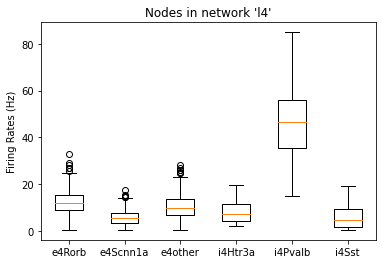

In [41]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.recurrent.json', group_by='cell_line')

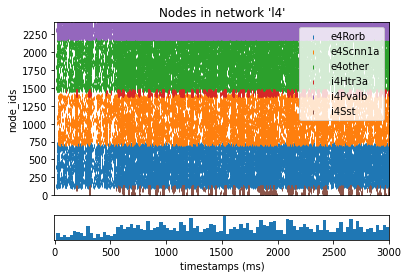

In [44]:
_ = plot_raster(config_file='config.simulation_pointnet.recurrent.json', group_by='cell_line')

#### Adding Perturbations

A common and useful tool in both in-silico and in-vivo neuroscience is the ability to enhance and/or inhibit different cell types. for example if we want to completely dishibit the i4Pvalb cells we can add a strong negative current clamp to the "inputs" section in the json config

```json
  "inputs": {
    "inh_current_clamp": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {"population": "l4", "cell_line": "i4Pvalb"},
        "amp": -2000.000,
        "delay": 1500.0,
        "duration": 1500.0
      }
```

2022-06-02 13:02:49,849 [INFO] Created log file
2022-06-02 13:02:49,884 [INFO] Batch processing nodes for l4/0.
2022-06-02 13:02:49,964 [INFO] Batch processing nodes for lgn/0.
2022-06-02 13:02:50,059 [INFO] Setting up output directory
2022-06-02 13:02:50,060 [INFO] Building cells.
2022-06-02 13:02:50,142 [INFO] Building recurrent connections
2022-06-02 13:02:50,854 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-02 13:03:03,202 [INFO] Network created.
2022-06-02 13:03:03,232 [INFO] Starting Simulation
2022-06-02 13:03:34,278 [INFO] Simulation finished, finalizing results.
2022-06-02 13:03:34,549 [INFO] Done.


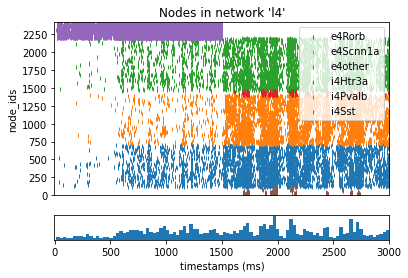

In [3]:
import math
import numpy as np

from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.pert_pvalb.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_pvalb.json', group_by='cell_line')

Not only are we able to completely knock out the Parvaralbium cells in Layer 4, we can see and compare the effect this has on the rest of the recurrently-connected network. Similary we can excite the cells with a strong positive current, or even excite/inhibite different cells at different times during the same simulation.